In [1]:
from pyspark.context import SparkContext
from pyspark.sql.context import SQLContext
from pyspark.sql.session import SparkSession

import re
import pandas as pd
    
sc = SparkContext()
sqlContext = SQLContext(sc)
spark = SparkSession(sc)

23/06/22 00:43:04 WARN Utils: Your hostname, Xinyis-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.0.201 instead (on interface en0)
23/06/22 00:43:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/06/22 00:43:05 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/06/22 00:43:06 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


/Users/jwang/opt/anaconda3/envs/DDS/lib/python3.10/site-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [2]:
from nasa_transformation import *

# Loading and Parsing NASA Log Dataset

In [3]:
input_file_path = ''
input_df = zip_log_to_df(input_file_path, spark)
input_df.take(10)

[Row(value='199.72.81.55 - - [01/Jul/1995:00:00:01 -0400] "GET /history/apollo/ HTTP/1.0" 200 6245'),
 Row(value='unicomp6.unicomp.net - - [01/Jul/1995:00:00:06 -0400] "GET /shuttle/countdown/ HTTP/1.0" 200 3985'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:09 -0400] "GET /shuttle/missions/sts-73/mission-sts-73.html HTTP/1.0" 200 4085'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/countdown/liftoff.html HTTP/1.0" 304 0'),
 Row(value='199.120.110.21 - - [01/Jul/1995:00:00:11 -0400] "GET /shuttle/missions/sts-73/sts-73-patch-small.gif HTTP/1.0" 200 4179'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /images/NASA-logosmall.gif HTTP/1.0" 304 0'),
 Row(value='burger.letters.com - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/video/livevideo.gif HTTP/1.0" 200 0'),
 Row(value='205.212.115.106 - - [01/Jul/1995:00:00:12 -0400] "GET /shuttle/countdown/countdown.html HTTP/1.0" 200 3985'),
 Row(value='d104.aa.net - - [01/Ju

In [4]:
# split the rows to columns
df = split_to_df(input_df,ts_pattern1)
df.show(10, truncate=True)

+--------------------+--------------------+------+--------------------+--------+------+------------+
|                host|           timestamp|method|            endpoint|protocol|status|content_size|
+--------------------+--------------------+------+--------------------+--------+------+------------+
|        199.72.81.55|01/Jul/1995:00:00...|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|
|unicomp6.unicomp.net|01/Jul/1995:00:00...|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|
|      199.120.110.21|01/Jul/1995:00:00...|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|
|  burger.letters.com|01/Jul/1995:00:00...|   GET|/shuttle/countdow...|HTTP/1.0|   200|    

# Handling Missing Data 

## Count Missing Values

In [5]:
df.columns

['host',
 'timestamp',
 'method',
 'endpoint',
 'protocol',
 'status',
 'content_size']

In [6]:
# count the number of missing values for each column
count_null_col(df).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     1|       33905|
+----+---------+------+--------+--------+------+------------+



## Show Missing Values

In [7]:
null_status_df = input_df.filter(~input_df['value'].rlike(r'\s(\d{3})\s'))
null_status_df.show(truncate=False)

+--------+
|value   |
+--------+
|alyssa.p|
+--------+



## Drop Missing Values 

In [8]:
df_clean = fill_null_values(df)

In [9]:
# count null values after cleaning
count_null_col(df_clean).show()

+----+---------+------+--------+--------+------+------------+
|host|timestamp|method|endpoint|protocol|status|content_size|
+----+---------+------+--------+--------+------+------------+
|   0|        0|     0|       0|       0|     0|           0|
+----+---------+------+--------+--------+------+------------+



# Data Engineering

## Format Timestamp

In [10]:
# format timpstamp to year-month-date format
df = month_to_num(df_clean)
df = format_timestamp(df)
df.show(10, truncate=True)

+--------------------+------+--------------------+--------+------+------------+-------------------+
|                host|method|            endpoint|protocol|status|content_size|               time|
+--------------------+------+--------------------+--------+------+------------+-------------------+
|        199.72.81.55|   GET|    /history/apollo/|HTTP/1.0|   200|        6245|1995-07-01 00:00:01|
|unicomp6.unicomp.net|   GET| /shuttle/countdown/|HTTP/1.0|   200|        3985|1995-07-01 00:00:06|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4085|1995-07-01 00:00:09|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   304|           0|1995-07-01 00:00:11|
|      199.120.110.21|   GET|/shuttle/missions...|HTTP/1.0|   200|        4179|1995-07-01 00:00:11|
|  burger.letters.com|   GET|/images/NASA-logo...|HTTP/1.0|   304|           0|1995-07-01 00:00:12|
|  burger.letters.com|   GET|/shuttle/countdow...|HTTP/1.0|   200|           0|1995-07-01 00:00:12|


# Data Analysis 

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pyspark.sql import functions as F
%matplotlib inline

## Content Size

In [11]:
content_size_summary_df = df.describe(['content_size'])
content_size_summary_df.toPandas()

,summary,content_size
0,count,3461612
1,mean,18928.844398216785
2,stddev,73031.47260949228
3,min,0
4,max,6823936


## HTTP Status

DataFrame[status: int, count: bigint]

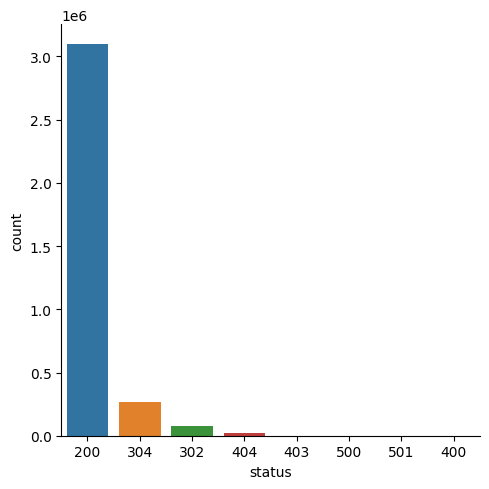

In [12]:
plot_status(df)

23/06/22 00:44:05 WARN CacheManager: Asked to cache already cached data.


DataFrame[status: int, count: bigint]

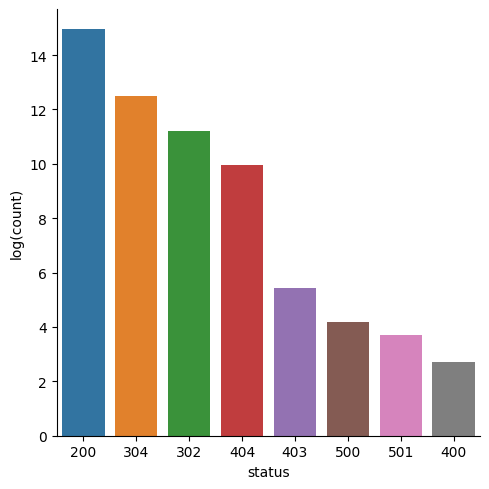

In [13]:
plot_log_status(df)

## Frequent Host

In [14]:
top_host(df, 5).show(truncate=False)

+--------------------+-----+
|host                |count|
+--------------------+-----+
|piweba3y.prodigy.com|21988|
|piweba4y.prodigy.com|16437|
|piweba1y.prodigy.com|12825|
|edams.ksc.nasa.gov  |11964|
|163.206.89.4        |9697 |
+--------------------+-----+



## Top EndPoint 

In [15]:
top_endpoint(df,10).show(truncate=False)

+---------------------------------------+------+
|endpoint                               |count |
+---------------------------------------+------+
|/images/NASA-logosmall.gif             |208714|
|/images/KSC-logosmall.gif              |164970|
|/images/MOSAIC-logosmall.gif           |127908|
|/images/USA-logosmall.gif              |127074|
|/images/WORLD-logosmall.gif            |125925|
|/images/ksclogo-medium.gif             |121572|
|/ksc.html                              |83909 |
|/images/launch-logo.gif                |76006 |
|/history/apollo/images/apollo-logo1.gif|68896 |
|/shuttle/countdown/                    |64736 |
+---------------------------------------+------+



## Top EndPoints by day of week

In [16]:
result = top_endpoint_by_day(df)
result.show(7, truncate=False)

+--------------------------+-----+-------------+
|endpoint                  |count|Day in a week|
+--------------------------+-----+-------------+
|/images/KSC-logosmall.gif |15218|Sunday       |
|/images/NASA-logosmall.gif|30380|Monday       |
|/images/NASA-logosmall.gif|33685|Tuesday      |
|/images/NASA-logosmall.gif|37598|Wednesday    |
|/images/NASA-logosmall.gif|46920|Thursday     |
|/images/NASA-logosmall.gif|29139|Friday       |
|/images/NASA-logosmall.gif|16168|Saturday     |
+--------------------------+-----+-------------+



## 404 status count by day of week

In [17]:
def error_count_by_day(df):
    df_404 = (df.filter(df['status'] == 404))
    status_day_df = df_404.select(df.endpoint, 
                             F.dayofweek('time').alias('weekday'))
    # group by weekday and the endpoint, aggregate by counts
    status_freq_df = (status_day_df
                     .groupBy('weekday')
                     .count()
                     .sort("weekday"))
    udf_parse_day = udf(parse_day_of_week)
    result = status_freq_df.select('*', udf_parse_day(status_freq_df['weekday']).alias('Day in a week')).drop('weekday')
    return result

In [18]:
error_by_day = error_count_by_day(df)
error_by_day.show(7, truncate=False)

+-----+-------------+
|count|Day in a week|
+-----+-------------+
|2400 |Sunday       |
|3145 |Monday       |
|3425 |Tuesday      |
|3397 |Wednesday    |
|3772 |Thursday     |
|2691 |Friday       |
|2069 |Saturday     |
+-----+-------------+



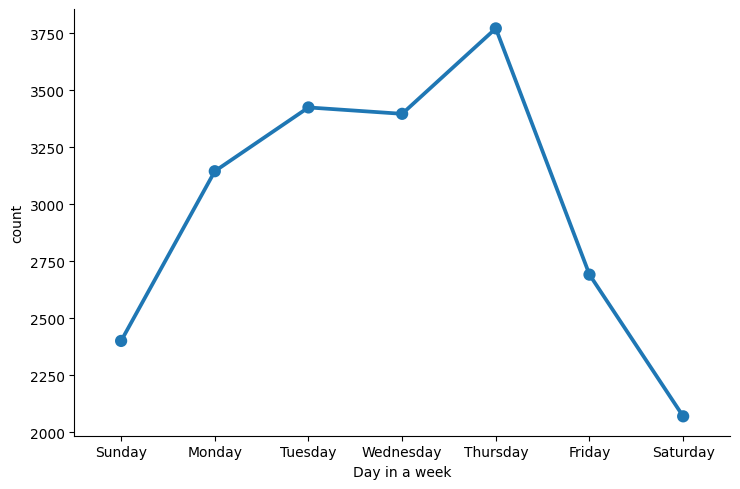

In [19]:
sns.catplot(x='Day in a week', y='count', 
                data=error_by_day.toPandas(), 
                kind='point', height=5, 
                aspect=1.5)